In [1]:
import torch
import tensorflow as tf
from torch import Tensor
from torch.distributions.transforms import Transform
import numpy as np
import zuko
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from torch import optim
import plot_loss
from tqdm.notebook import trange

2023-01-13 11:43:43.296426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 11:43:44.595824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-01-13 11:43:44.596025: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-0

In [2]:
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()
from memflow.phasespace import  phasespace
from memflow.hardscatter import hardscatter

2023-01-13 11:43:45.919102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-01-13 11:43:45.919320: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
[INFO] (pdfflow.pflow) Loading member 0 from NNPDF40_nnlo_hessian_pdfas
[INFO] (pdfflow.pflow) Building tf.Graph, this can take a while...


# Build the flow

In [3]:
from zuko.flows import TransformModule, SimpleAffineTransform
from zuko.distributions import BoxUniform

In [4]:
def build_flow(ntransforms=4, hidden_mlp=[32]*3, bins=8, autoregressive=True):
    features = 7
    flow = zuko.flows.NSF(features, transforms=ntransforms, bins=bins, hidden_features=hidden_mlp, 
                      randperm=True,
                      base=BoxUniform,
                      base_args=[torch.ones(features)*(-1),torch.ones(features)],
                      univariate_kwargs={"bound": 1 }, # Keeping the flow in the [-1,1] box.
                      passes= 2 if not autoregressive else features)

    flow.transforms.insert(0, SimpleAffineTransform(0*torch.ones(features),1*torch.ones(features),
                                                 -1*torch.ones(features), 1*torch.ones(features)))
    
    return flow

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
flow = build_flow()
flow

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1.])] -> [tensor([-1., -1., -1., -1., -1., -1., -1.]), tensor([1., 1., 1., 1., 1., 1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0, 0, 0, 1, 0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=32, out_features=32, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=32, out_features=32, bias=True)
        (5): ReLU()
        (6): MaskedLinear(in_features=32, out_features=161, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 0, 0, 1, 0, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=32, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_featu

In [5]:
%%timeit
x3 = flow().sample((10000,))

119 ms ± 8.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0.5, 0, 'x2')

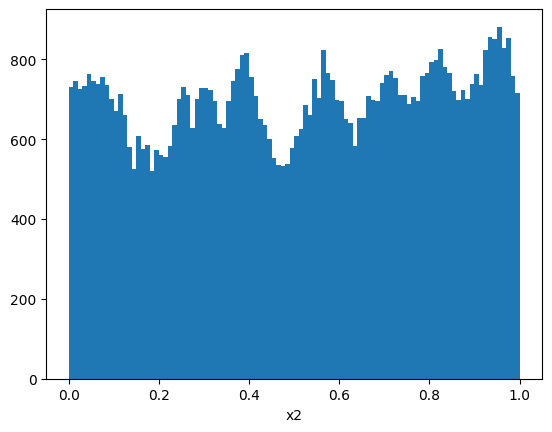

In [6]:
x3 = flow().sample((10000,))
plt.hist(x3.flatten(), bins=100, range=(0,1))
plt.xlabel("x2")

In [6]:
count_parameters(flow)

NameError: name 'flow' is not defined

# Train the Madgraph probability

In [7]:
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()

[INFO] (pdfflow.pflow) Loading member 0 from NNPDF40_nnlo_hessian_pdfas
[INFO] (pdfflow.pflow) Building tf.Graph, this can take a while...


In [8]:
from memflow.phasespace import  phasespace
from memflow.hardscatter import hardscatter

In [11]:
E_CM = 13000
N = 10000
rambo = phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6], pdf=None)

In [12]:
ps = flow().sample((10000,))
momenta, w , x1, x2 = rambo.get_momenta_from_ps(ps)

In [13]:
pdf_weight =  phasespace.get_pdf_weight(x1, x2, [21,21], pdf)

Text(0, 0.5, 'Top pz')

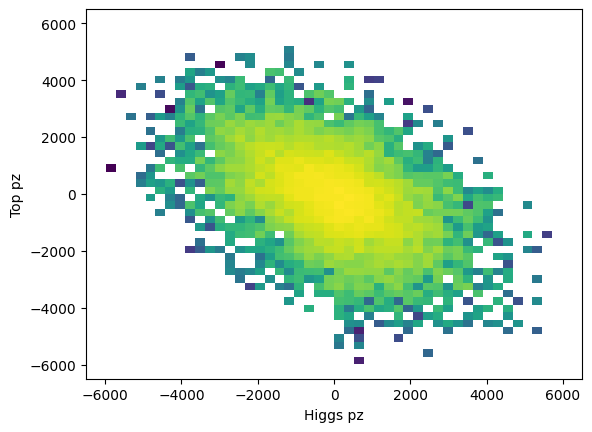

In [15]:
plt.hist2d(momenta[:, 2, -1].numpy(),
           momenta[:, 4, -1].numpy(), 
           range=((-6500.,6500.), (-6500.,6500.)), bins=(50,50),
           weights=w*pdf_weight,
           norm=LogNorm())
plt.xlabel("Higgs pz")
plt.ylabel("Top pz")

In [16]:
with torch.no_grad():
    smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
    shat = x1 * x2 * E_CM**2
    target = smatrix*pdf_weight/(2*shat)
    # The target is the smatrix * pdf * (1/(2s)) * rambo_jacobian
    logp_target = torch.log(target)

Text(0.5, 0, 'Target log(p)')

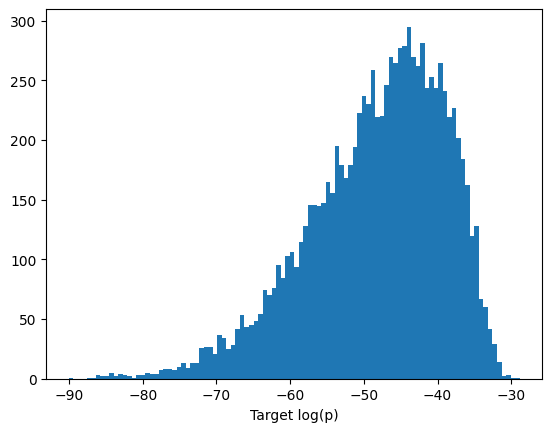

In [17]:
plt.hist(logp_target, bins=100)
plt.xlabel("Target log(p)")

### Forward logprob computation of the flow

In [18]:
# Adding log(detRambo^-1) = - log(detRambo) to the jacobian
logp_g =  flow().log_prob(ps) - w.log()

Text(0.5, 0, 'Flow log prob')

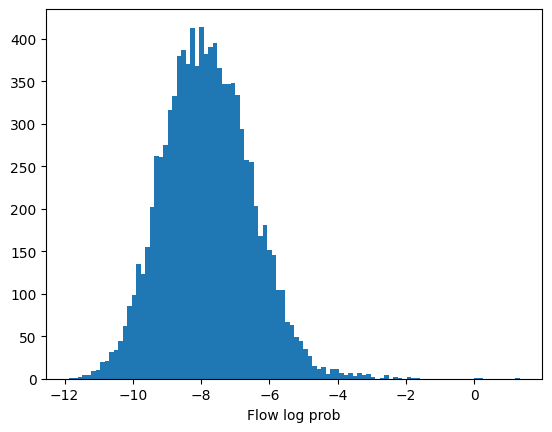

In [19]:
plt.hist(logp_g.detach().numpy(), bins=100)
plt.xlabel("Flow log prob")
#plt.yscale("log")

In [20]:
nanmask = ~logp_target.isnan()

In [27]:
loss = logp_g[nanmask] - logp_target[nanmask]

In [28]:
loss.mean()

tensor(40.4464, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [ ]:
loss.mean().backward()

Text(0.5, 0, 'loss')

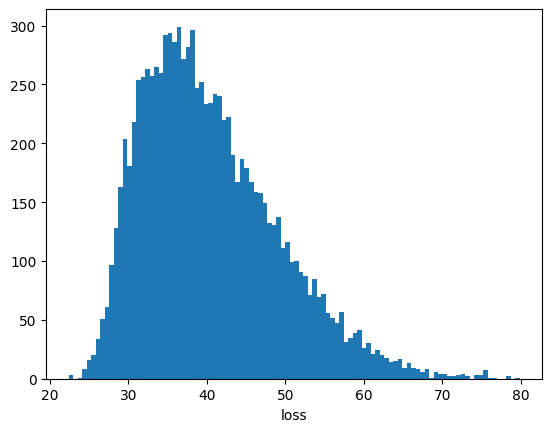

In [30]:
plt.hist(loss.detach().numpy(), bins=100)
plt.xlabel("loss")

# Training loop 

In [5]:
nepochs = 300
nsamples = 10000

In [20]:
flow = build_flow(2, [128]*4, bins=10, autoregressive=True)
optimizer = optim.SGD(flow.parameters(), lr=0.001)
plotter = plot_loss.LossPlotter(["loss","xs","xs_variance"])

E_CM = 13000
rambo = phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6], pdf=None)

In [21]:
count_parameters(flow)

153494

In [22]:
flow

NSF(
  (transforms): ModuleList(
    (0): SimpleAffineTransform([tensor([0., 0., 0., 0., 0., 0., 0.]), tensor([1., 1., 1., 1., 1., 1., 1.])] -> [tensor([-1., -1., -1., -1., -1., -1., -1.]), tensor([1., 1., 1., 1., 1., 1., 1.])])
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [3, 6, 4, 5, 0, 2, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=7, out_features=128, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): MaskedLinear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
        (8): MaskedLinear(in_features=128, out_features=203, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=10)
      (order): [3, 1, 6, 2, 4, 0, 5]
      (hyper): MaskedMLP(
        (0): MaskedLine

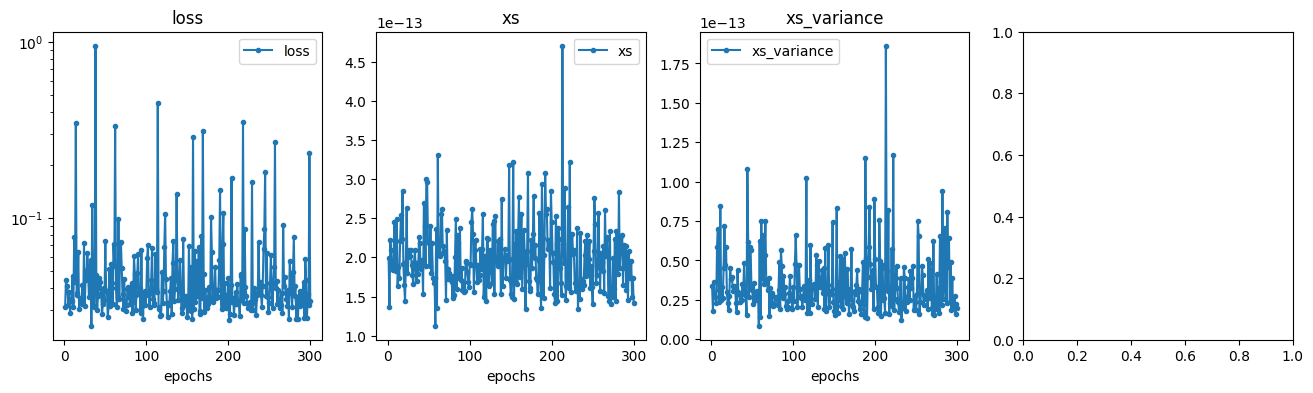

In [23]:
for i in range(nepochs):
    
    with torch.no_grad():
        ps = flow().sample((nsamples,))
        momenta, rambo_jac , x1, x2 = rambo.get_momenta_from_ps(ps)
        pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
    
        # evaluate the smatrix 
        smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
        shat = x1 * x2 * E_CM**2
        # Target function with pdf and 1/2s
        target = smatrix*pdf_weight/(2*shat)
        # nanmask for target=nan
        nanmask = (target>0)
        logp_target = target.log()[nanmask]
        
        
    # Computing the reversed KL divergence loss
    optimizer.zero_grad()
    
    # Adding log(detRambo^-1) = - log(detRambo) to the jacobian
    logp_g =  (flow().log_prob(ps) - rambo_jac.log())[nanmask]

    
    rkl_loss = ((logp_g - logp_target)*logp_g.exp()).mean()
    rkl_loss.backward()
    
    optimizer.step()     
    
    with torch.no_grad():
        # Metrics
        xs = torch.sum(logp_target.exp()/logp_g.exp())/nsamples    
        xs_variance = torch.sqrt((1/(nsamples-1))*(torch.sum((logp_target.exp()/logp_g.exp())**2)/nsamples - (xs)**2))
    
    plotter.on_epoch_end({"loss": rkl_loss.item(), 
                          "xs": xs.item(),
                          "xs_variance": xs_variance.item()})
    
        

(0.0, 0.2)

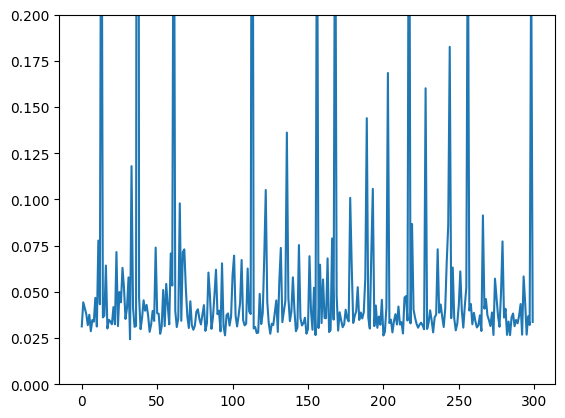

In [26]:
plt.plot(np.arange(300), plotter.metrics["loss"])
plt.ylim(0.,0.2)

In [47]:
ps_test = flow().sample((1000000, ))

(array([[ 89.,  90.,  89., ..., 114., 111.,  85.],
        [104., 109., 114., ..., 107.,  73.,  97.],
        [ 93., 103.,  96., ..., 114.,  95.,  85.],
        ...,
        [ 65., 109.,  79., ..., 101.,  87.,  90.],
        [ 96.,  73.,  88., ...,  89.,  93.,  99.],
        [ 99.,  78.,  91., ..., 103., 107.,  95.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99,

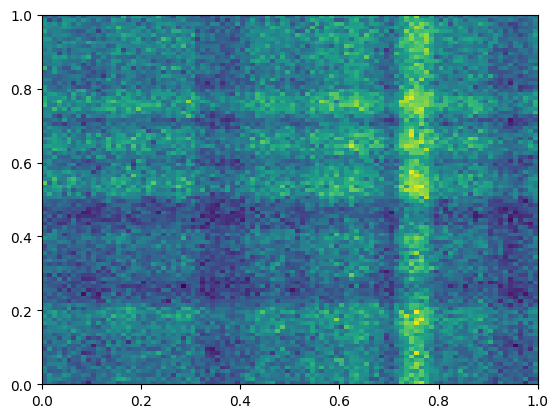

In [49]:
plt.hist2d(ps_test[:,-1].numpy(),
         ps_test[:,-2].numpy(),
         bins=100,
         range=((0,1),(0,1)))

# Buffered training

In [65]:
N_generations = 300
N_buffered_epochs = 2
batch_size = 1024
N = 51200
lr_init = 0.00001


In [66]:
flow = build_flow(10, [32]*3, bins=15, autoregressive=False)
optimizer = optim.Adam(flow.parameters(), lr=lr_init)

decay = 0.01
fcn = lambda step: 1./(1. + decay*step)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=fcn)

plotter = plot_loss.LossPlotter(["loss_epoch", "sampling_weight_mean","sampling_weight_std",
                                "loss_gen","xs_gen","xs_var_gen","lr" ])
print(count_parameters(flow))
E_CM = 13000
rambo = phasespace.PhaseSpace(E_CM, [21,21], [25,6,-6], pdf=None)


125320


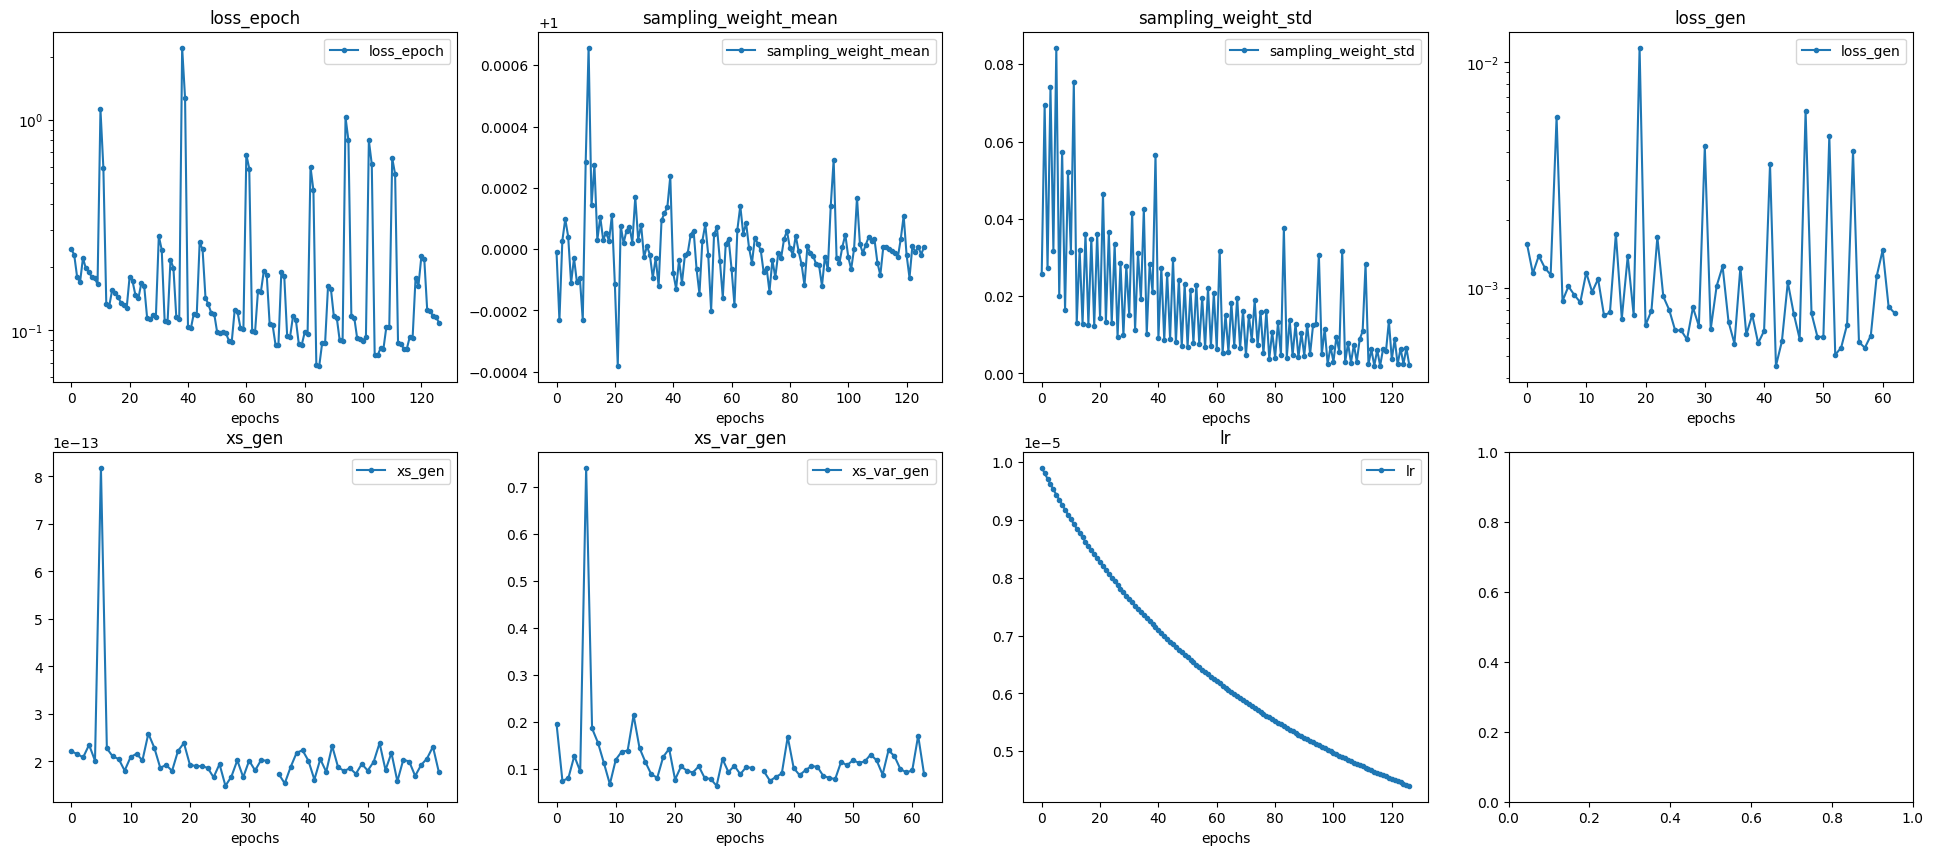

Batch:   0%|          | 0/50 [00:00<?, ?it/s]

RuntimeError: grad can be implicitly created only for scalar outputs

In [67]:
for g in trange(N_generations, desc="Generation"):
    print(f"Generation: {g}")
    # For each epoch we take N samples and then we use them for batched training
    with torch.no_grad():
        print(f"Generating {N} samples")
        ps = flow().sample((N,))
        momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps)
        #avoid borders with ps=1
        rambo_nan = rambo_jac.isnan()
        pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
    
        # evaluate the smatrix 
        print(f"Computing the target prob of {N} samples")
        smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
        shat = x1 * x2 * E_CM**2
        # Target function with pdf and 1/2s
        target = smatrix*pdf_weight/(2*shat)
        # nanmask for target=nan
        nanmask = (target>0)&(~rambo_nan)
        ps = ps[nanmask]
        target = target[nanmask]
        rambo_jac = rambo_jac[nanmask]
        logp_target = target.log()
        # Compute the sampling prob just once
        print(f"Computing the sampling prob of {N} samples")
        logp_sampling = flow().log_prob(ps) - rambo_jac.log()
    
    Ngood = nanmask.sum()
    generation_loss = 0

    for e in trange(N_buffered_epochs,desc="Buffered epochs"):
        
        # Now we can loop on matching batches
        epoch_loss = 0
        epoch_sampling_weight_mean = 0.
        epoch_sampling_weight_std = 0.
        nbuff_epochs = 0
        
        permutation = torch.randperm(Ngood)
        
        for i in trange(0, Ngood, batch_size, desc="Batch"):
            
            indices = permutation[i:i+batch_size]
            
            nbuff_epochs+=1
            ps_i = ps[indices]
            rambo_jac_i = rambo_jac[indices]
            nanmask_i = nanmask[indices]
            logp_target_i = logp_target[indices]

            # Computing the reversed KL divergence loss
            optimizer.zero_grad()

            # Adding log(detRambo^-1) = - log(detRambo) to the jacobian
            logp_g =  flow().log_prob(ps_i) - rambo_jac_i.log()
            assert logp_g.isnan().sum() == 0

            # sampling difference weight
            sampling_weight = (logp_g.exp()/logp_sampling[indices].exp()) 

            # Weight the loss by logp_g/logp_sampling
            #rkl loss
            loss = (((logp_g - logp_target_i)*logp_g.exp()) * sampling_weight ).mean()
            #remove loss isnan
            loss = loss[~loss.isnan()]
            # Variance loss
            #loss = torch.sum((logp_target_i.exp()**2/(logp_g.exp()*logp_sampling[indices].exp())))/Ngood - \
            #        (torch.sum((logp_target_i.exp())/(logp_sampling[indices].exp()))/Ngood)**2
            
            assert loss.isnan().sum() == 0
            loss.backward()

            optimizer.step()    

            epoch_loss += loss.item()
            epoch_sampling_weight_mean += sampling_weight.mean().item()
            epoch_sampling_weight_std += sampling_weight.std().item()
            
        # Decrease learing rate 
        scheduler.step()
        
        with torch.no_grad():
            generation_loss+= epoch_loss/nbuff_epochs
            plotter.on_epoch_end({"loss_epoch": epoch_loss/nbuff_epochs,
                                 "sampling_weight_mean": epoch_sampling_weight_mean/nbuff_epochs,
                                 "sampling_weight_std": epoch_sampling_weight_std/nbuff_epochs,
                                 "lr": scheduler.get_lr()})
    
        
    with torch.no_grad():
        # Compute the XS as validation 
        logp_g_val =  flow().log_prob(ps) - rambo_jac.log()
        xs = torch.sum(logp_target.exp()/logp_g_val.exp())/Ngood
        
        xs_variance = torch.sqrt((1/(Ngood-1))*(torch.sum((logp_target.exp()/logp_g_val.exp())**2)/Ngood - (xs)**2))
        
        plotter.on_epoch_end({"loss_gen": generation_loss/N_generations,
                             "xs_gen": xs.item(),
                             "xs_var_gen": xs_variance.item()/xs.item()})
        

    
        

In [22]:
a = ((logp_g - logp_target_i)*logp_g.exp())

In [23]:
torch.argmax(a)

tensor(299)

In [24]:
logp_g[299]

tensor(-inf, dtype=torch.float64, grad_fn=<SelectBackward0>)

In [25]:
logp_target_i[299]

tensor(-51.0790, dtype=torch.float64)

In [27]:
logp_g.exp()[299]

tensor(0., dtype=torch.float64, grad_fn=<SelectBackward0>)

In [21]:
((logp_g - logp_target_i)*logp_g.exp()).isnan().sum()

tensor(1)

In [ ]:
torch.where((logp_g - logp_target_i)*logp_g.exp())

In [17]:
loss.isnan().sum()

tensor(1)

In [68]:
ps_test = flow().sample((100000, ))

(array([[ 4.,  3.,  4., ..., 19., 10., 10.],
        [ 1.,  5.,  6., ...,  7., 10.,  9.],
        [ 0.,  1.,  0., ...,  0.,  3.,  3.],
        ...,
        [13.,  6.,  5., ..., 17., 15.,  6.],
        [ 1.,  0.,  5., ..., 16.,  9.,  7.],
        [ 9.,  8.,  4., ..., 13., 18., 12.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 array([0.  , 0.01, 0.02, 0

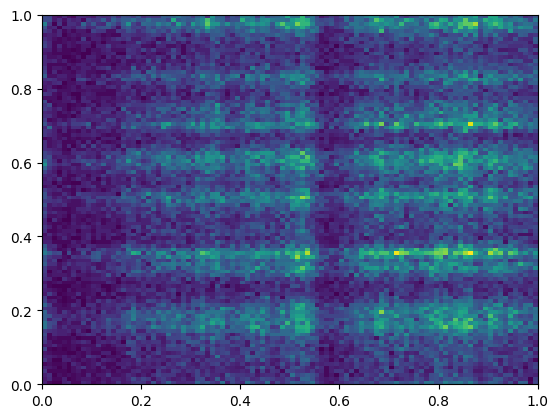

In [70]:
plt.hist2d(ps_test[:,-2].numpy(),
         ps_test[:,-1].numpy(),
         bins=100,
         range=((0,1),(0,1)))

In [71]:
logp_g = flow().log_prob(ps_test)
momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps_test)
pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
shat = x1 * x2 * E_CM**2
# Target function with pdf and 1/2s
target = smatrix
logp_target = target.log()

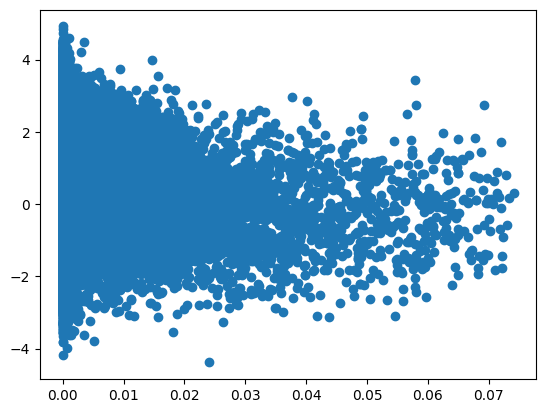

In [72]:
plt.scatter(pdf_weight, logp_g.detach().numpy())

(array([ 167.,  330.,  337.,  382.,  411.,  450.,  510.,  543.,  546.,
         588.,  643.,  674.,  672.,  777.,  886., 1028., 1199., 1278.,
        1246., 1285., 1314., 1324., 1216., 1045.,  912.,  782.,  718.,
         671.,  682.,  726.,  884., 1108., 1198., 1171., 1230., 1566.,
        1668., 1470., 1258., 1003.,  875.,  834.,  814.,  849.,  841.,
         837.,  784.,  861.,  962., 1117., 1265., 1431., 1374., 1205.,
        1001.,  942., 1046., 1081., 1200., 1270., 1461., 1532., 1508.,
        1456., 1207.,  957.,  809.,  738.,  785., 1098., 1550., 1429.,
        1324., 1210., 1224., 1109., 1036.,  856.,  750.,  708.,  716.,
         915., 1125., 1325., 1203.,  956.,  803.,  748.,  671.,  639.,
         666.,  664.,  710.,  830.,  922., 1199., 1503., 1873., 1790.,
        1508.]),
 array([0.03742828, 0.04705394, 0.05667961, 0.06630527, 0.07593094,
        0.0855566 , 0.09518226, 0.10480793, 0.11443359, 0.12405925,
        0.13368492, 0.14331059, 0.15293625, 0.16256191, 0.17218758

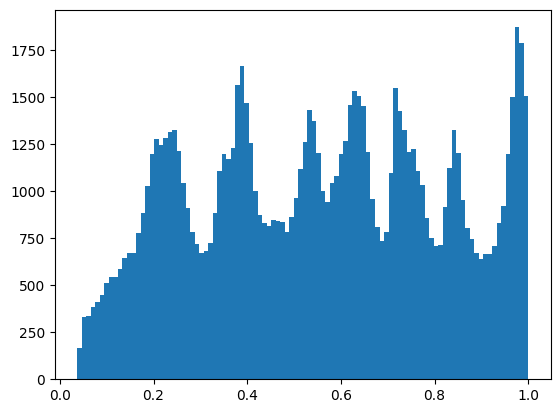

In [74]:
plt.hist(x2.numpy(), bins=100)

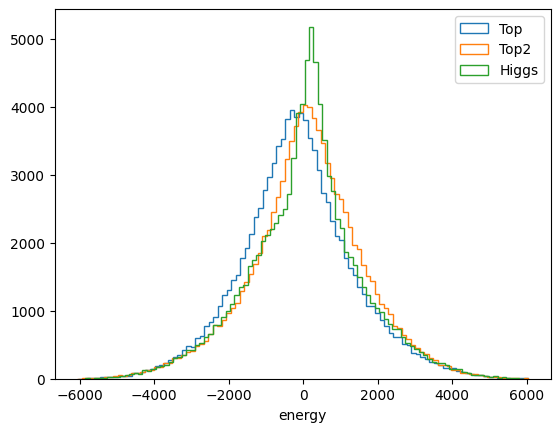

In [89]:
plt.hist(momenta[:,4,-1].numpy(), bins=100, histtype="step", label="Top")
plt.hist(momenta[:,3,-1].numpy(), bins=100, histtype="step", label="Top2")
#plt.hist(momenta[:,0,1].numpy(), bins=100, histtype="step", label="Gluon")
#plt.hist(momenta[:,1,1].numpy(), bins=100, histtype="step", label="Gluon2")
plt.hist(momenta[:,2,-1].numpy(), bins=100, histtype="step", label="Higgs")
plt.xlabel("energy")
plt.legend()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([   0.,   65.,  130.,  195.,  260.,  325.,  390.,  455.,  520.,
         585.,  650.,  715.,  780.,  845.,  910.,  975., 1040., 1105.,
        1170., 1235., 1300., 1365., 1430., 1495., 1560., 1625., 1690.,
        1755., 1820., 1885., 1950., 2015., 2080., 2145., 2210., 2275.,
        2340., 2405., 2470., 2535., 2600., 2665., 2730., 2795., 2860.,
        2925., 2990., 3055., 3120., 3185., 3250., 3315., 3380., 3445.,
        3510., 3575., 3640., 3705., 3770., 3835., 3900., 3965., 4030.,
        4095., 4160., 4225., 4290., 4355., 4420., 4485., 4550., 4615.,
        4680., 4745., 4810., 4875., 4940., 5005., 5070., 5135., 5200.,
        5265., 5330., 5395., 5460., 5525., 5590., 5655., 5720., 5785.,
        5850., 5915., 5980., 6045., 6110.

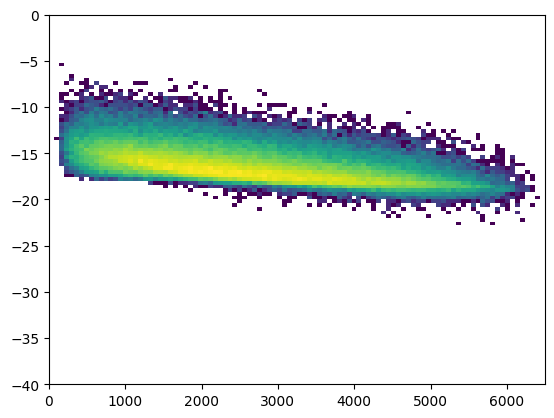

In [55]:
plt.hist2d(momenta[:,2,0].numpy(), logp_target.numpy(),
          bins=(100,100),
           range=((0.,6500.),(-40.,0.)), norm=LogNorm())

# Study of the target

In [216]:
ps_test = torch.rand(1500000, 7)
momenta, rambo_jac, x1, x2 = rambo.get_momenta_from_ps(ps_test)
pdf_weight = phasespace.get_pdf_weight(x1,x2,[21,21], pdf)
smatrix = hardscatter.eval_smatrix_batch([21,21,25,6,-6], momenta)
shat = x1 * x2 * E_CM**2
# Target function with pdf and 1/2s
target = smatrix
tot_target = (smatrix*pdf_weight/(2*shat)).log().numpy()
logp_target = target.log().numpy()

tot_target[np.isnan(tot_target)] = 0.

## Gluons and |M|^2 target

Text(0, 0.5, '|M|^2')

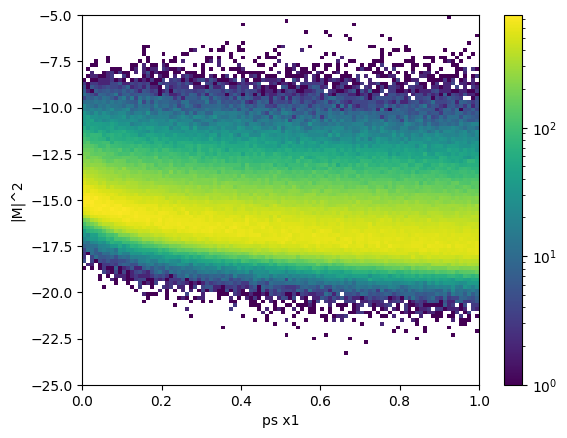

In [118]:
plt.hist2d(ps_test[:,-1].numpy(), 
           logp_target,
          bins=100, range=((0, 1), (-25,-5)), 
          norm=LogNorm())
plt.xlabel("ps x1")
plt.colorbar()
plt.ylabel("|M|^2")

Text(0, 0.5, '|M|^2')

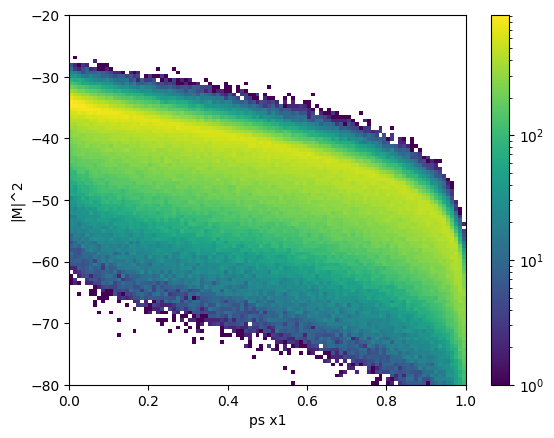

In [125]:
plt.hist2d(ps_test[:,-1].numpy(), 
           tot_target,
          bins=100, range=((0, 1), (-80,-20)), 
          norm=LogNorm())
plt.xlabel("ps x1")
plt.colorbar()
plt.ylabel("|M|^2")

Text(0.5, 0, 'ps x2')

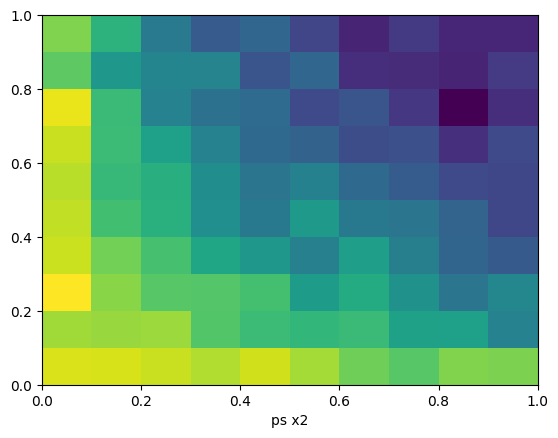

In [119]:
plt.hist2d(ps_test[:,-1].numpy(), 
           ps_test[:,-2].numpy(),
           weights=logp_target,
          bins=10, range=((0, 1), (0,1)))
plt.xlabel("ps x1")
plt.xlabel("ps x2")

## PS points vs target

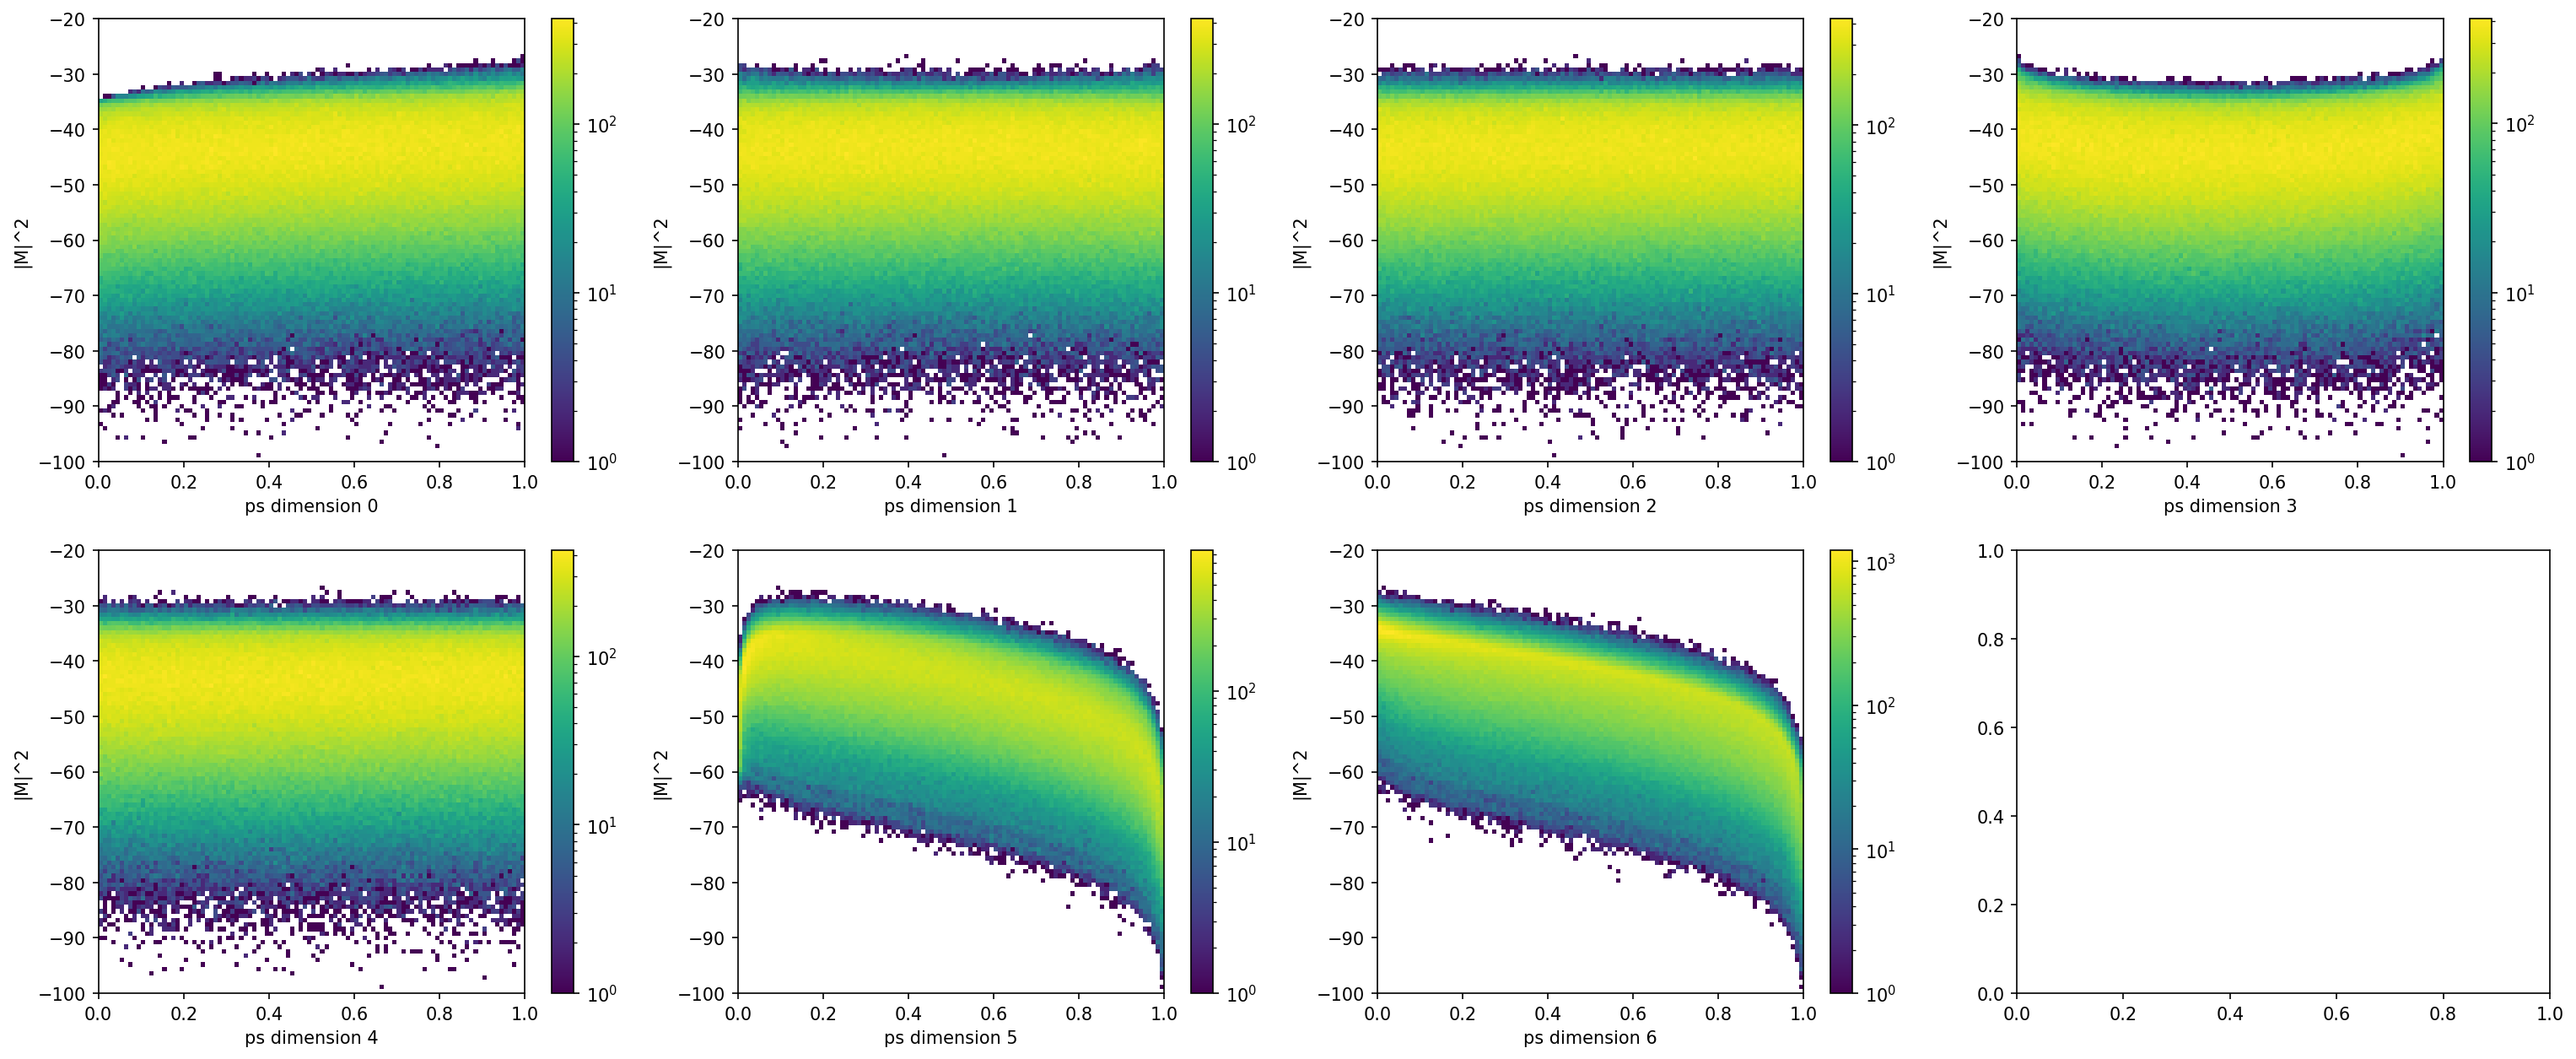

In [152]:
fig , axs = plt.subplots(2, 4, figsize=(25, 10), dpi=150)

for i in range(7):
    ax = axs[i //4][i %4]
    a,b,c, I = ax.hist2d(ps_test[:,i].numpy(), 
           tot_target,
           bins=100, range=((0, 1), (-100,-20)), 
           norm=LogNorm())
    ax.set_xlabel(f"ps dimension {i}")
    plt.colorbar(I, ax=ax)
    ax.set_ylabel("|M|^2")

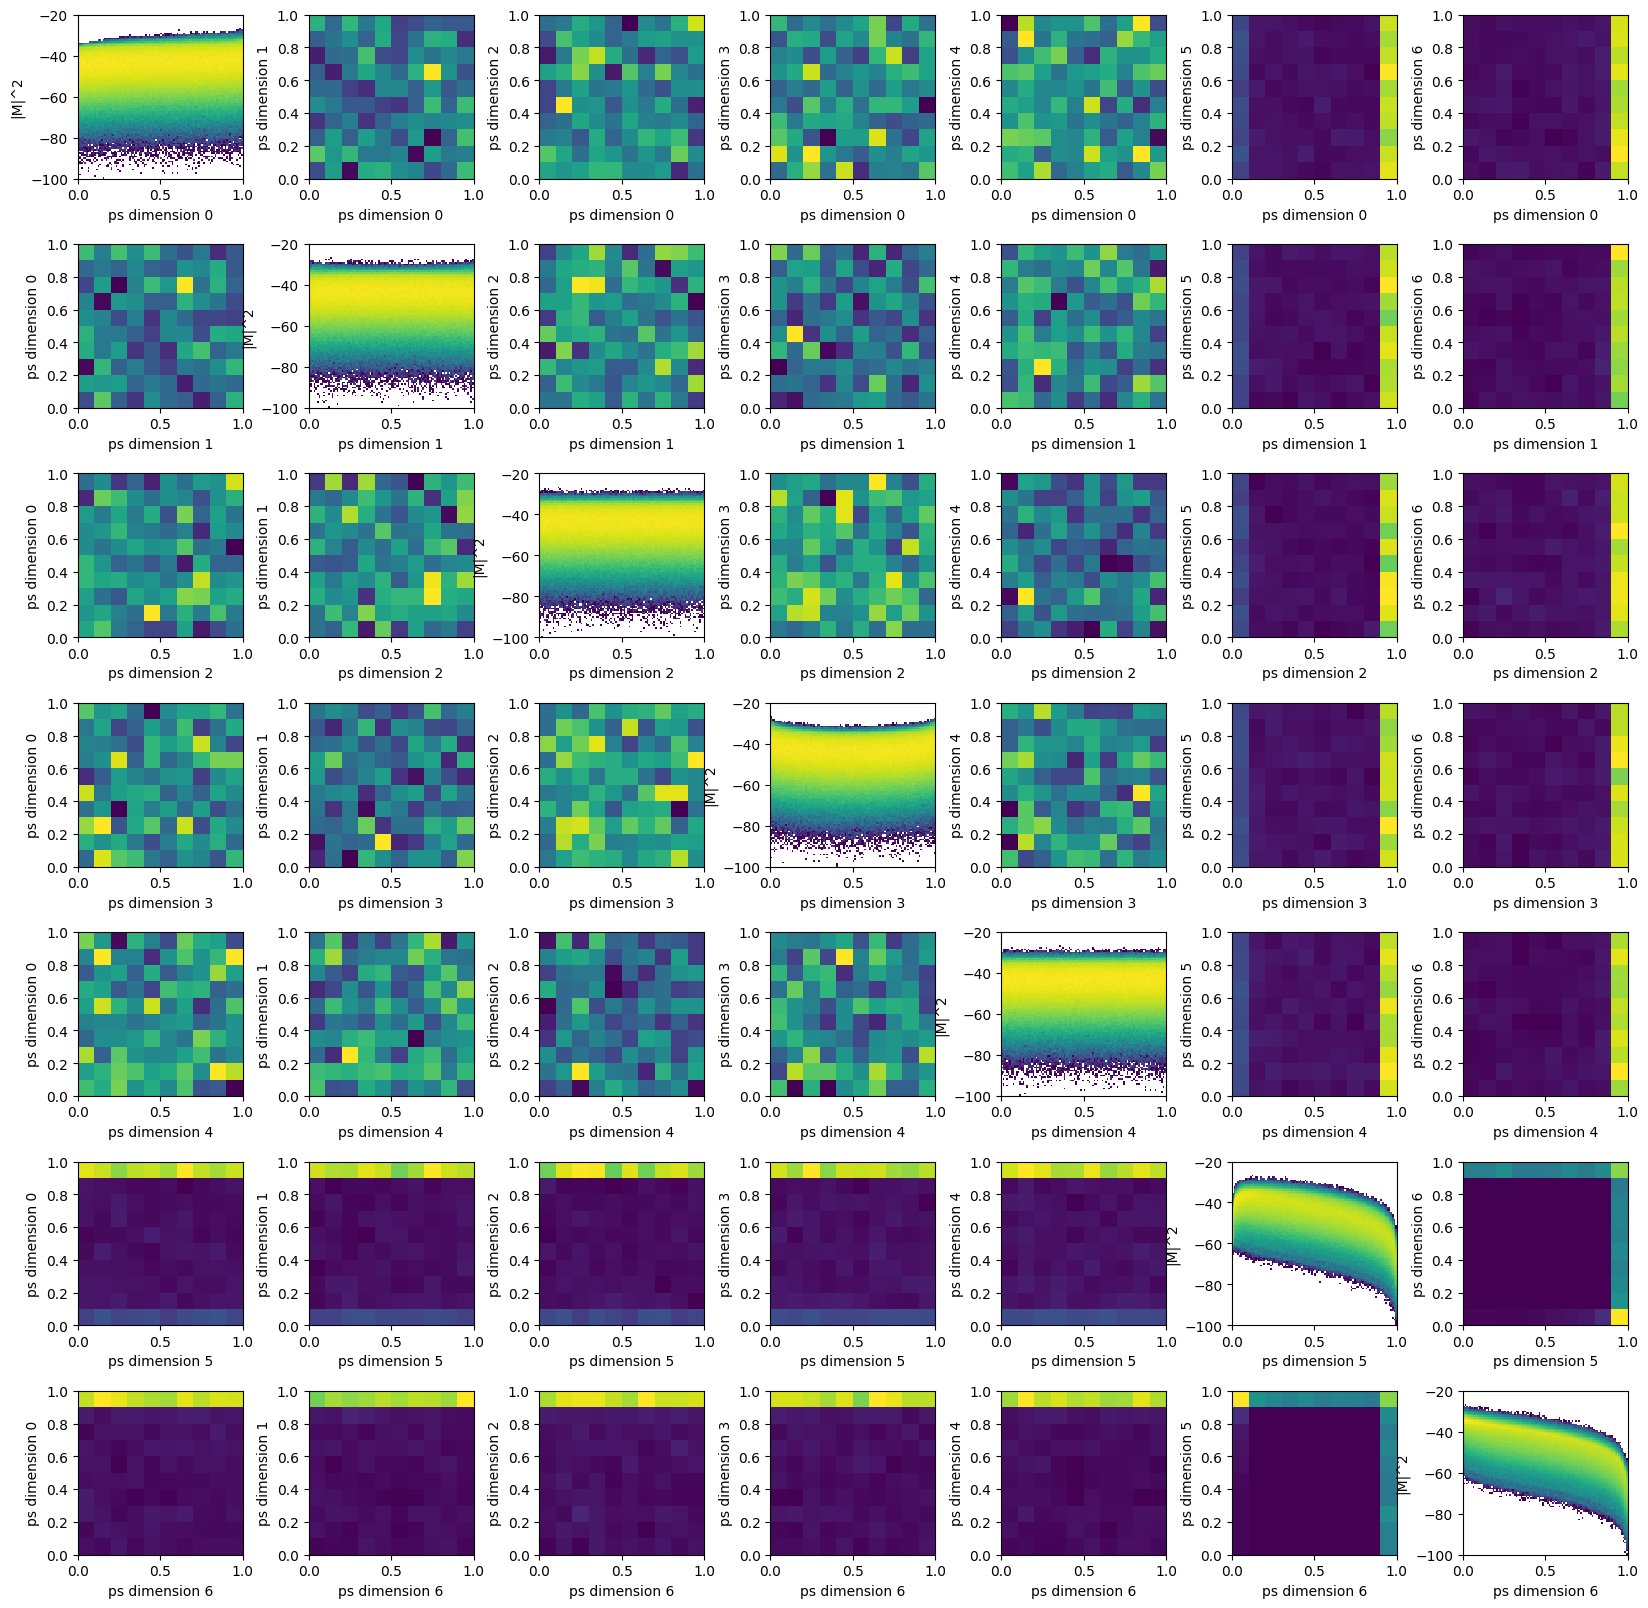

In [229]:
fig , axs = plt.subplots(7, 7, figsize=(20, 20), dpi=100)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(7):
    for j in range(7):
        ax = axs[i][j]
        # if j>i: 
        #     fig.delaxes(ax)
        #     continue
        
        if i == j:
            a,b,c, I = ax.hist2d(ps_test[:,i].numpy(), 
                   tot_target,
                   bins=100, range=((0, 1), (-100,-20)), 
                   norm=LogNorm())
            ax.set_xlabel(f"ps dimension {i}")
            #plt.colorbar(I, ax=ax)
            ax.set_ylabel("|M|^2")
        else:
            H, bx,by = np.histogram2d(
                ps_test[:,i].numpy(), 
                ps_test[:,j].numpy(),
                weights=np.exp(tot_target),
            bins=10, range=((0, 1), (0,1)))
            X, Y = np.meshgrid(bx, by)
            ax.pcolormesh(X, Y, H/1e6)
            ax.set_xlabel(f"ps dimension {i}")
            ax.set_ylabel(f"ps dimension {j}")
            #plt.colorbar(I, ax=ax, label="sum |M|^2")

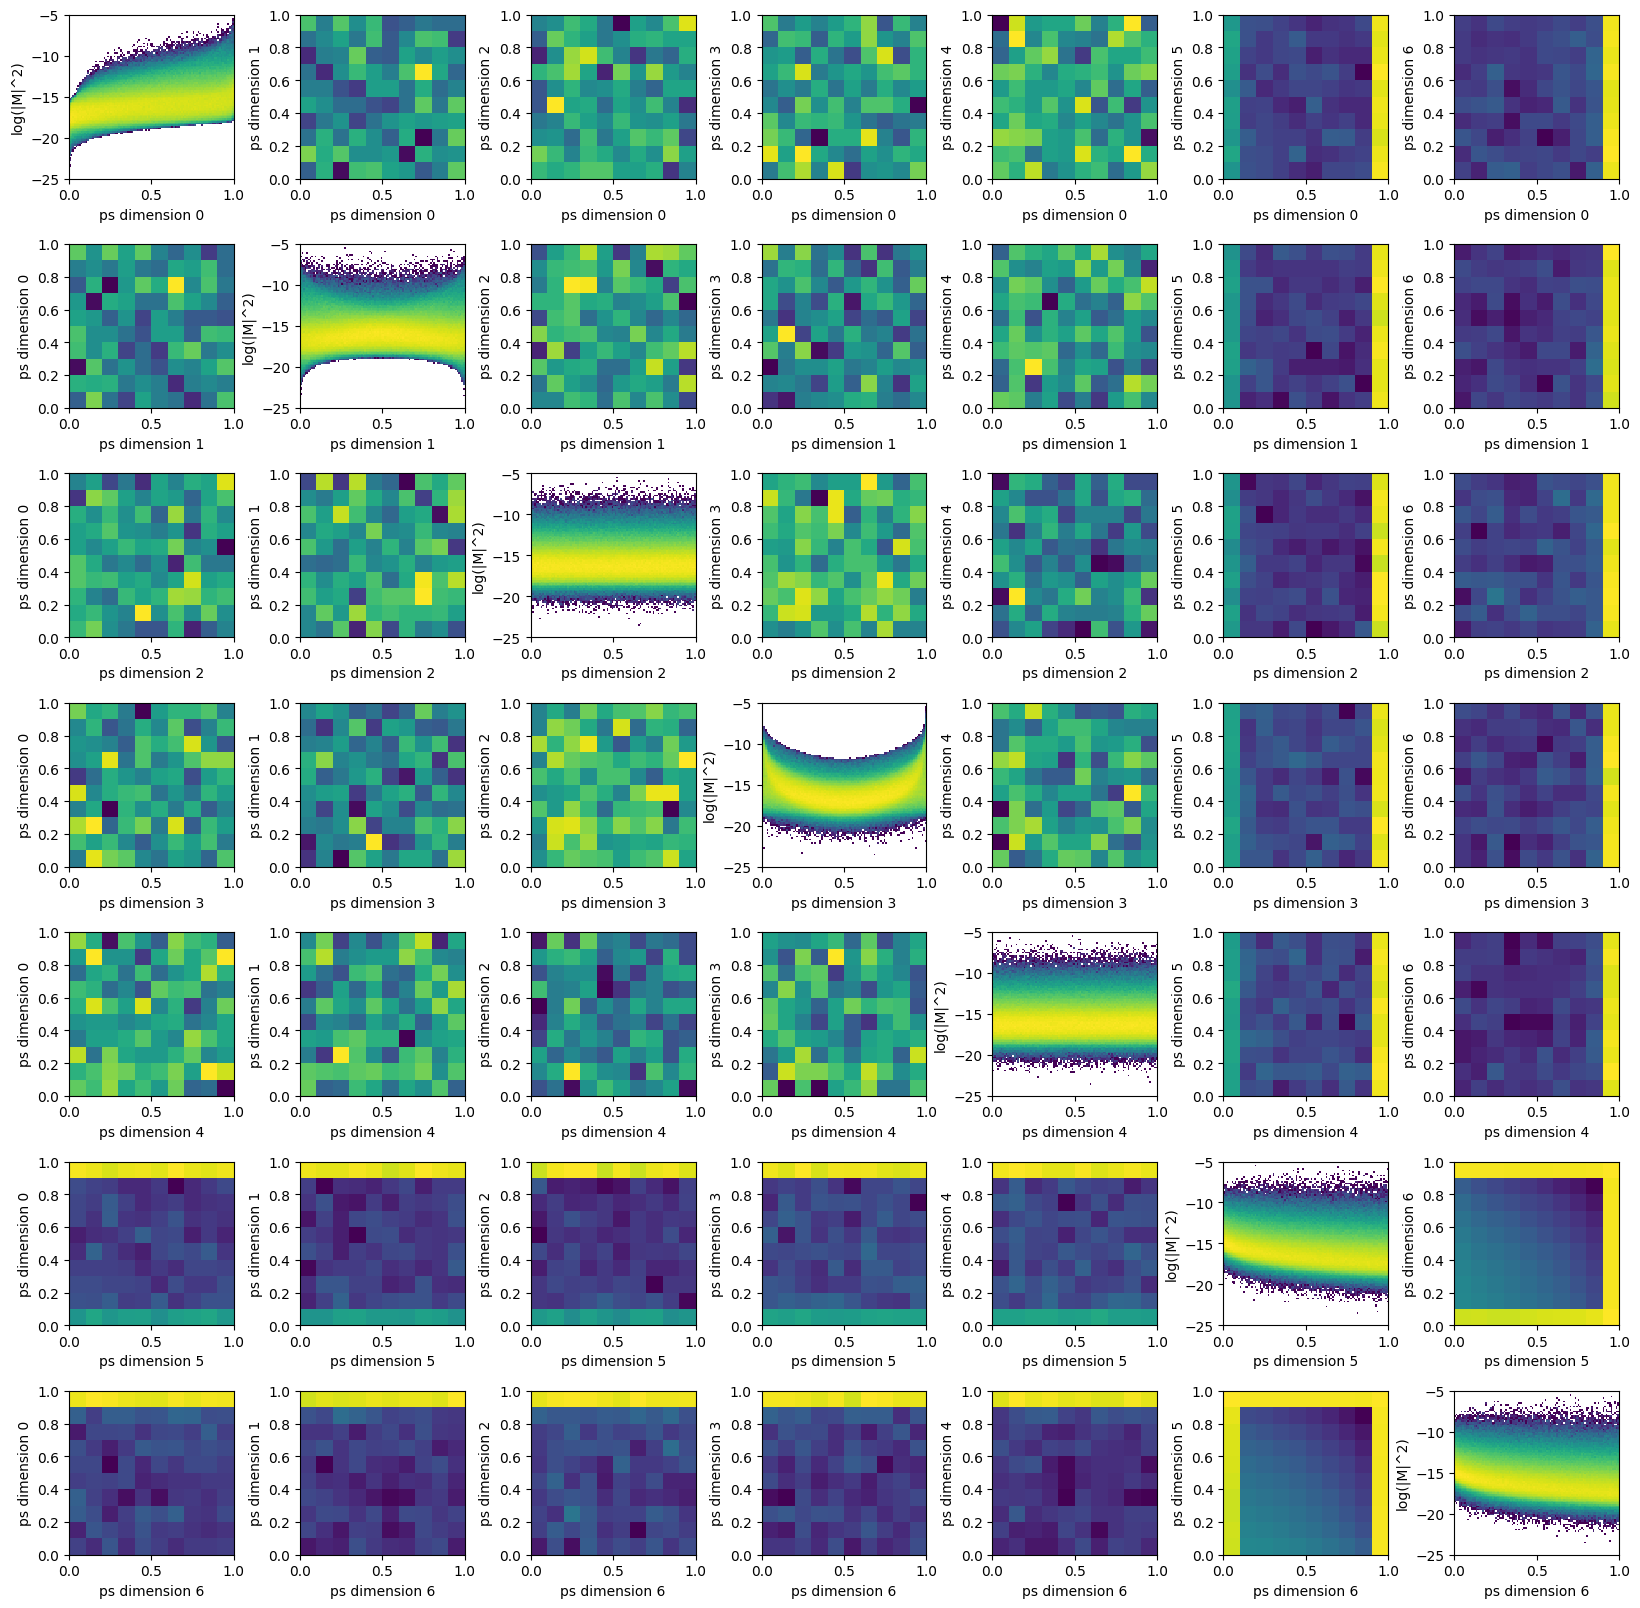

In [228]:
fig , axs = plt.subplots(7, 7, figsize=(20, 20), dpi=100)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for i in range(7):
    for j in range(7):
        ax = axs[i][j]
        # if j>i: 
        #     fig.delaxes(ax)
        #     continue
        
        if i == j:
            a,b,c, I = ax.hist2d(ps_test[:,i].numpy(), 
                   logp_target,
                   bins=100, range=((0, 1), (-25,-5)), 
                   norm=LogNorm())
            ax.set_xlabel(f"ps dimension {i}")
            #plt.colorbar(I, ax=ax)
            ax.set_ylabel("log(|M|^2)")
        else:
            H, bx,by = np.histogram2d(
                ps_test[:,i].numpy(), 
                ps_test[:,j].numpy(),
                weights=np.exp(tot_target),
            bins=10, range=((0, 1), (0,1)))
            X, Y = np.meshgrid(bx, by)
            ax.pcolormesh(X, Y, np.log(H/1.5e6))
            ax.set_xlabel(f"ps dimension {i}")
            ax.set_ylabel(f"ps dimension {j}")
            #plt.colorbar(I, ax=ax, label="sum |M|^2")